#### In this notebook, you can find various functions and code for exploring and analysing your initial scan images data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
import SimpleITK as sitk
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)
import utils



## EDA on the APOLLO dataset

In [2]:
# Load all ct scan files
DATA_PATH = r'E:\Aibota\annotated_data_bii'

image_paths = []
aorta_mask_paths = []
for folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if filename == 'og_ct.nii':
                image_paths.append(file_path)
            elif filename == 'aorta_mask.nii':
                aorta_mask_paths.append(file_path)

assert len(image_paths) == len(aorta_mask_paths)
print("Number of patients data: ", len(image_paths))

Number of patients data:  270


In [3]:
def read_image(ct_path):
    if os.path.exists(ct_path):
        itkimage = sitk.ReadImage(ct_path)
        ct_scan = sitk.GetArrayFromImage(itkimage)
        spacing = np.array(list(itkimage.GetSpacing()))
        return ct_scan, spacing
    else:
        print("The file path doesn't exist")

In [4]:
# Load scan image data and spacing
scans, shapes, spacings = [], [], []
masks = []
for i in range(len(image_paths)):
  ct_im, spacing_im = read_image(image_paths[i])
  mask, spacing_mask = read_image(aorta_mask_paths[i])
  assert ct_im.shape == mask.shape, f'CT image and the mask doesnt have equal size respectively at: {image_paths[i]} and {aorta_mask_paths[i]}'
  assert all(spacing_im == spacing_mask), f'CT image and the mask doesnt have equal spacing respectively at: {image_paths[i]} and {aorta_mask_paths[i]}'
  scans.append(ct_im)
  masks.append(mask)
  shapes.append(ct_im.shape)
  spacings.append(spacing_im)

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: C:\Miniconda\envs\bld\conda-bld\work\b\ITK\Modules\IO\NIFTI\src\itkNiftiImageIO.cxx:588:
ITK ERROR: NiftiImageIO(000001CE45A72D80): nifti_image_load failed for file: E:\Aibota\annotated_data_bii\PD075\aorta_mask.nii

In [13]:
print(image_paths[36])
im, s = read_image(image_paths[36])
im.shape

E:\Aibota\annotated_data_bii\PD038\og_ct.nii


(54, 512, 512)

In [14]:
# Check for inconsistency in [z, w, h] of images
print("Min shape: ", min(shapes))
print("Max shape: ", max(shapes))
dims_df = pd.DataFrame(shapes, columns=['z', 'height', 'width'])
dims_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})

Min shape:  (40, 512, 512)
Max shape:  (54, 512, 512)


,height,width,count
0,512,512,190


We can see that all of the {len(image_paths)} scans have consistent width and height (512 by 512 pixels), though the number of slices vary from 40 to 54, let's plot number of slices to have a better visualization

In [16]:
print("Total number of slices: ", dims_df['z'].sum())

Total number of slices:  9095


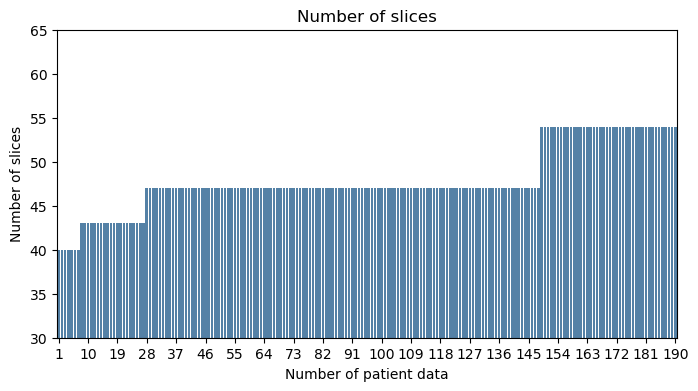

In [33]:
#plot number of slice distribution
def plot_slice_dist(dims_df):
    import matplotlib.ticker as mticker
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x=[x for x in range(1, len(dims_df)+1)], y=sorted(dims_df['z']), ax=ax, color='steelblue')
    myLocator = mticker.MultipleLocator(9)
    plt.gca().xaxis.set_major_locator(myLocator)
    plt.xlabel("Number of patient data")
    plt.ylabel("Number of slices")
    plt.ylim(30, 65)
    plt.title("Number of slices")
    plt.show()

plot_slice_dist(dims_df)

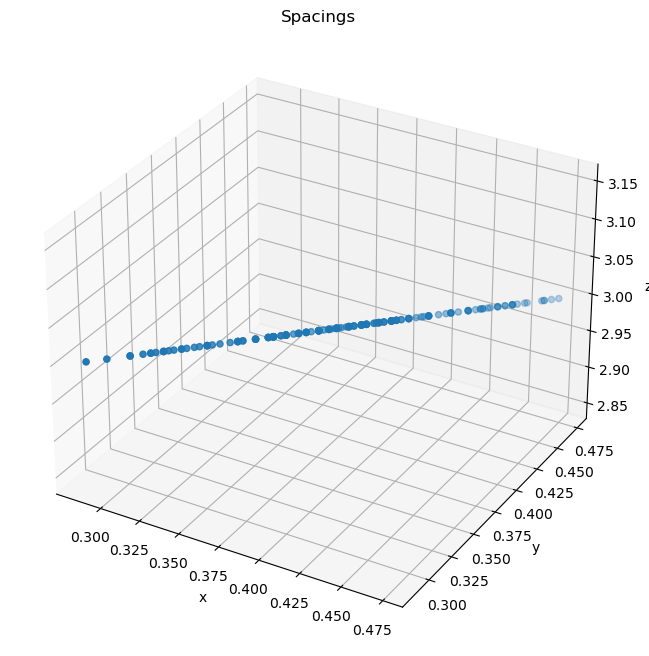

In [71]:
def plot_spacing(spacings):
    #converting to numpy arrays
    spacing_data = np.array(spacings)
    # Create a 3D plot
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(spacing_data[:, 0], spacing_data[:, 1], spacing_data[:, 2])
    # Add labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title("Spacings")
    # Display the plot
    plt.show()

plot_spacing(spacings)

In [52]:
spacing_df = pd.DataFrame(spacings, columns=['x', 'y', 'z'])
spacing_df.groupby(['x', 'y', 'z']).size().reset_index().rename(columns={0:'count'})

,x,y,z,count
0,0.285,0.285,3.0,1
1,0.293,0.293,3.0,1
2,0.302,0.302,3.0,2
3,0.307,0.307,3.0,1
4,0.310,0.310,3.0,2
...,...,...,...,...
67,0.460,0.460,3.0,1
68,0.466,0.466,3.0,1
69,0.467,0.467,3.0,2
70,0.470,0.470,3.0,1


In [53]:
def visualize_intensity(scans, row=3, col=4, xmin=-300, xmax=400):
  fig, ax = plt.subplots(row, col, figsize=(col*3,row*2))
  fig.suptitle("Pixel intensity visualization")
  n = 0
  for i in range(row):
    for k in range(col):
      ax[i,k].hist((scans[n]).ravel(), xmax-xmin, [xmin, xmax], color='steelblue')
      ax[i,k].set_ylabel("Number Of Pixels")
      ax[i,k].set_xlabel(f"Pixel Intensity from {xmin} to {xmax}")
      ax[i,k].set_title(image_paths[n].split('\\')[-1])
      n = n + 1
  fig.tight_layout()
  plt.show()

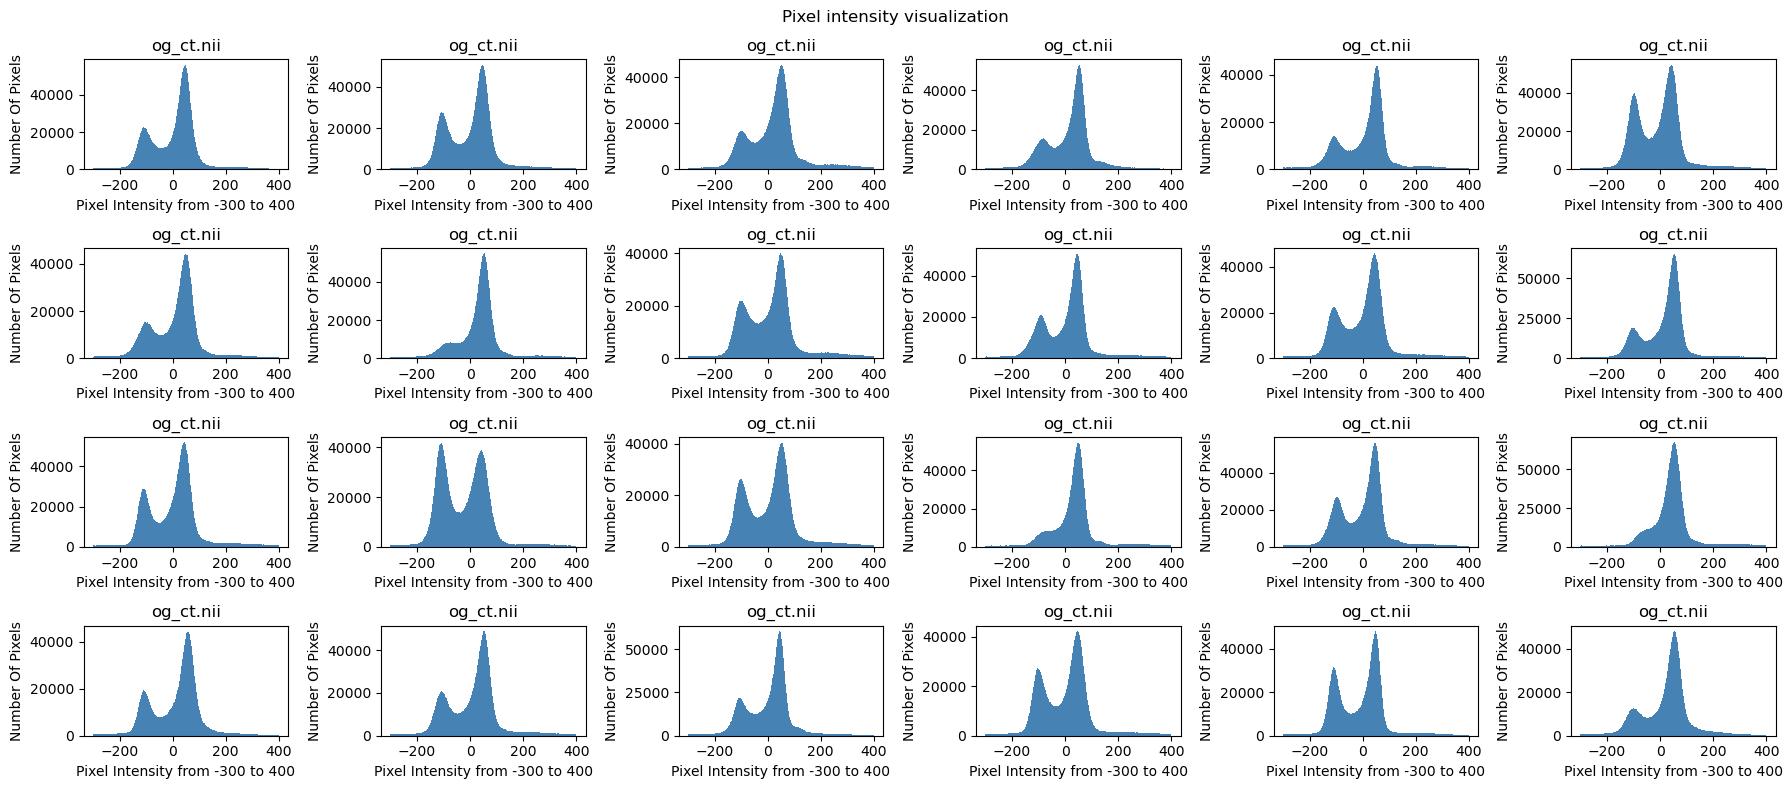

In [72]:
visualize_intensity(scans, row=4, col=6)

In [55]:
def visualize_intensity_range(scans):
    line = []
    x = []
    for i in range(len(scans)):
        line.append(scans[i].ravel().max())
        line.append(scans[i].ravel().min())
        x.append(i)
        x.append(i)

    sns.lineplot(x=x, y=(line))
    plt.xlabel("# scan")
    plt.ylabel("Intensity range")
    plt.show()


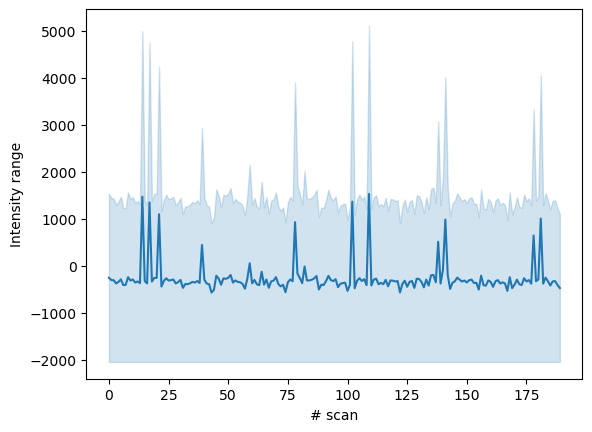

In [56]:
visualize_intensity_range(scans)

In [57]:
def count_mask_slices(mask):
    """Given a mask of shape 3D, return a count of number of slices that contain a segmentation"""
    count = 0
    for i in range(mask.shape[0]):
        if sum(mask[i].ravel() > 0): #if there is a segmentation mask in slice i
            count = count + 1
    return count

In [58]:
def count_mask_slices(mask):
    """Given a mask of shape 3D, return a count of number of slices that contain a segmentation"""
    count = 0
    for i in range(mask.shape[0]):
        if sum(mask[i].ravel() > 0): #if there is a segmentation mask in slice i
            count = count + 1
    return count

masks_size = []
non_zero_masks =[]
for i in range(len(masks)):
    masks_size.append(masks[i].shape[0])
    non_zero_masks.append(count_mask_slices(masks[i]))

In [69]:
print(f"Total number of slices across {len(masks_size)} CT images: ", sum(masks_size))
print('Total sum of slices with segmentation masks: ', sum(non_zero_masks))
print("Percentage of slices contain segmentation mask: {:.2f}%".format(sum(non_zero_masks) / sum(masks_size) * 100))

Total number of slices across 190 CT images:  9095
Total sum of slices with segmentation masks:  3937
Percentage of slices contain segmentation mask: 43.29%


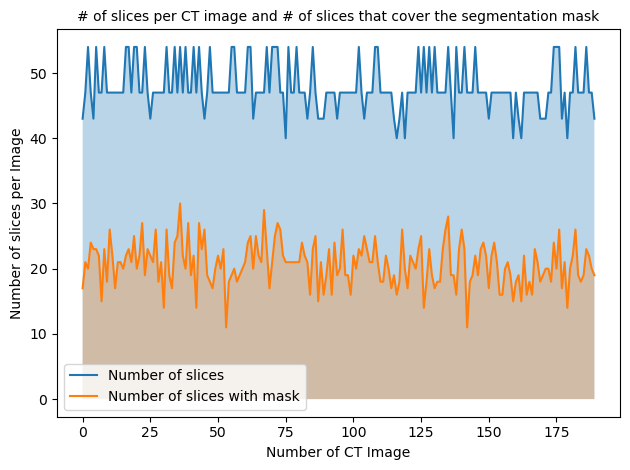

In [70]:
x = [x for x in range(len(masks_size))]
plt.plot(masks_size, label='Number of slices')
plt.fill_between(x, masks_size, alpha=0.3)
plt.plot(non_zero_masks, label='Number of slices with mask')
plt.fill_between(x, non_zero_masks, alpha=0.3)
plt.title("# of slices per CT image and # of slices that cover the segmentation mask", fontsize=10)
plt.xlabel("Number of CT Image")
plt.ylabel("Number of slices per Image")
plt.tight_layout()
plt.legend()
plt.show()

In [77]:
#How many have LM Calcification?
count = 0
for patient_folder in os.listdir(DATA_PATH):
    PD_path = os.path.join(DATA_PATH, patient_folder)
    if os.path.isdir(PD_path):
        for file in os.listdir(PD_path):
            if file[-6:] == 'LM.xls':
                count = count + 1
print(f"Out of {len(image_paths)} patients data, {count} of them have Left Main (LM) artery calcification")

Out of 190 patients data, 28 of them have Left Main (LM) artery calcification


In [74]:
s = '118_calcium_score_LM.xls'
s[-6:]

'LM.xls'

So far we have:
1. Confirmed that each CT image and its corresponsing mask has the same size and spacing
2. All of the image slices are same sized (512, 512)
3. The spacing actoss z direction is consistent == 3.0, however spacing across x and y directions vary from 0.285 to 0.473
4. Plotted pixel intensity histogram, and verified not all the images follow the same distribution.
5. There are outliners in terms of HU intensity shooting all the way up to 5000
6. Calculated the number of slices with segmentation mask for each CT image and saw that distribution is not consistent over all images (this is not really a problem)
7. Only 43% of slices across all dataset will have ground truth labels (since others are considered background, they will have emtpy label text file).
8. Out of all patients data, only 28 of them have Left Main (LM) artery calcification

## EDA on the orCaScore dataset

In [8]:
# Load all ct scan files
DATA_PATH = r'C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\bifurcation_point'

image_paths = []
for folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith(".nii"):
                image_paths.append(os.path.join(folder_path, filename))

In [9]:
# Load scan image data
scans, shapes, spacings = [], [], []
for im_path in image_paths:
  ct_scan, spacing = utils.read_nifti_image(im_path, spacing=True)
  scans.append(ct_scan)
  shapes.append(ct_scan.shape)
  spacings.append(spacing)


In [10]:
# Check for inconsistency in [z, w, h] of images
print("Min shape: ", min(shapes))
print("Max shape: ", max(shapes))
dims_df = pd.DataFrame(shapes, columns=['z', 'height', 'width'])
dims_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})

Min shape:  (36, 512, 512)
Max shape:  (64, 512, 512)


,height,width,count
0,512,512,31


In [11]:
print("Total number of slices: ", dims_df['z'].sum())

Total number of slices:  1498


We can see that all of the 31 scans have consistent width and height (512 by 512 pixels), though the number of slices vary from 36 to 64, let's plot number of slices to have a better visualization

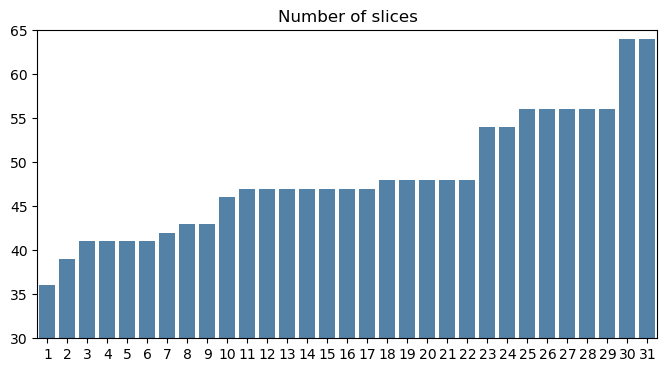

In [10]:
#plot number of slice distribution
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=[x for x in range(1, 32)], y=sorted(dims_df['z']), ax=ax, color='steelblue')
plt.ylim(30, 65)
plt.title("Number of slices")
plt.show()

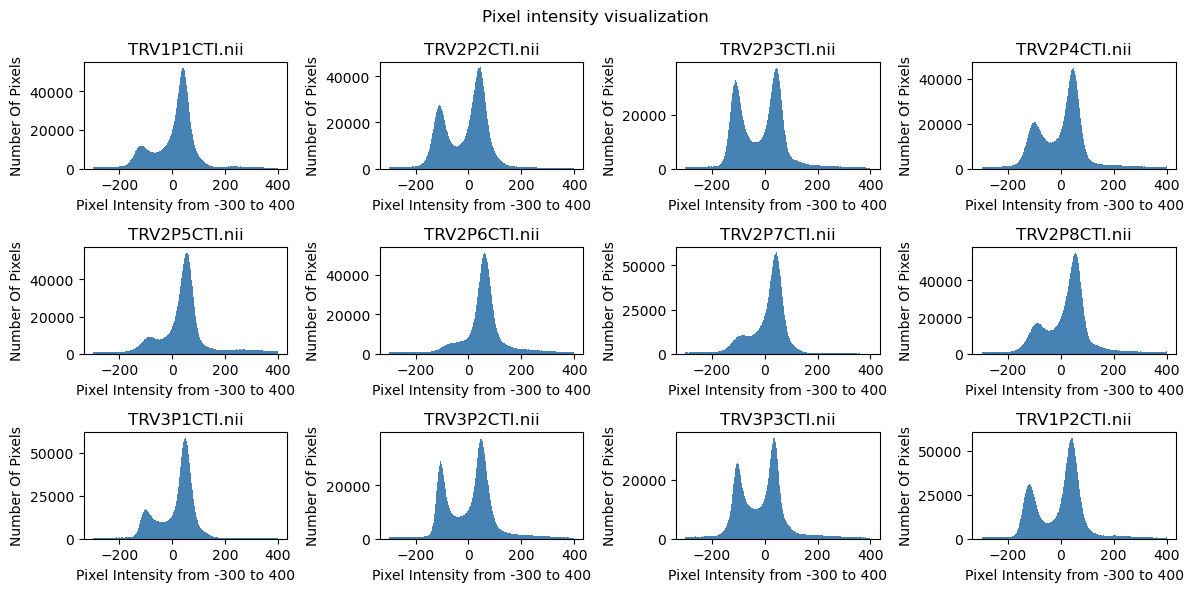

In [13]:
#Visualizing pixel intensity distribution
visualize_intensity(scans)

The HU values usually fall between -1000, 1000, anything above or below is considered outliers or error. Let's check for outliers, we want to cut intensity to be in the acceptable range in the preprocessing step

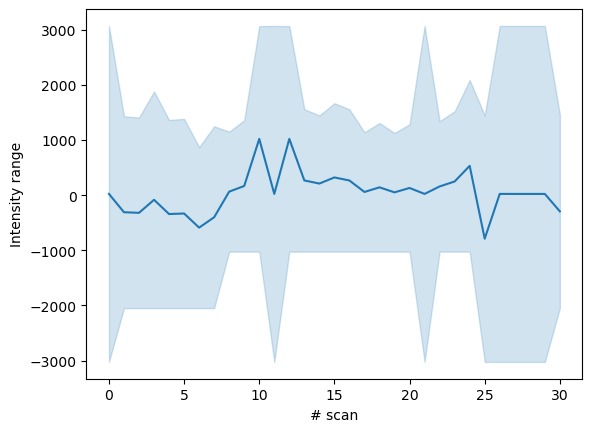

In [27]:
visualize_intensity_range(scans)

We can see that intensity ranges as much as below -3000 and above +3000 for some scan images <br>
Now let's see if the spacing is consistent across all scan images

In [16]:
spacing_df = pd.DataFrame(spacings, columns=['z', 'x', 'y'])
spacing_df.groupby(['x', 'y', 'z']).size().reset_index().rename(columns={0:'count'})

,x,y,z,count
0,0.328125,0.328125,3.0,1
1,0.353516,0.353516,3.0,1
2,0.373047,0.373047,3.0,1
3,0.382812,0.382812,3.0,2
4,0.386719,0.386719,3.0,1
5,0.392578,0.392578,3.0,1
6,0.410156,0.410156,2.5,1
7,0.417969,0.417969,3.0,1
8,0.419922,0.419922,2.5,1
9,0.425781,0.425781,2.5,1
